# Lead Conversion Prediction

A rapidly growing company, aims to optimize its sales process and enhance customer retention through data-driven insights. In a competitive market, it is crucial to efficiently allocate sales resources and proactively engage with customers.

**Your task is to develop a machine learning model that predicts the likelihood of a lead converting (or a customer churning) based on historical customer data.** This model will serve as a strategic tool for our sales team, enabling them to prioritize their efforts, improve efficiency, and implement targeted engagement strategies to maximize conversion rates and minimize churn.

# Phase 1: Data Loading & Initial Inspection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Loading & Initial Inspection ---
# Task: Load the dataset into a Pandas DataFrame.
# Display the first few rows, check the data types of each column,
# and obtain a summary of descriptive statistics.
try:
    # Ensure the path is correct relative to where the script is run
    df = pd.read_csv('data/dataset-big.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'data/dataset-big.csv' not found. Please ensure the file is in the correct path.")
    # Create an empty DataFrame to avoid errors in subsequent steps if file is not found
    df = pd.DataFrame()
    print("Creating an empty DataFrame. Please ensure 'data/dataset-big.csv' exists and is accessible.")

if not df.empty:
    print("\n--- Initial Data Inspection ---")
    # Display the first few rows of the dataset.
    print("First 5 rows of the dataset:")
    print(df.head())

    # Check the data types of each column and obtain non-null counts.
    print("\nInformation about the dataset (data types and non-null counts):")
    df.info()

    # Obtain a summary of descriptive statistics for numerical columns.
    print("\nDescriptive statistics of the dataset:")
    print(df.describe())

    # --- Missing Value Identification (Initial) ---
    # Task: Identify columns with missing values and quantify their extent.
    print("\n--- Missing Value Identification ---")
    # Identify columns with missing values and quantify their extent.
    missing_values = df.isnull().sum()
    # Filter to show only columns with missing values
    print("Missing values before any handling:\n", missing_values[missing_values > 0])
else:
    print("\nDataFrame is empty. Cannot perform initial data inspection.")

Dataset loaded successfully.

--- Initial Data Inspection ---
First 5 rows of the dataset:
  customer_id subscription_type  monthly_bill  data_usage_gb  \
0       C0001             Basic         50.89          11.55   
1       C0002        Enterprise        520.19          75.44   
2       C0003           Premium        152.05          41.84   
3       C0004             Basic         43.32          10.40   
4       C0005             Basic         51.90          24.67   

   support_tickets_opened  last_login_days_ago  contract_length_months  \
0                       4                 4.59                      24   
1                       0                13.35                       1   
2                       3                42.12                       1   
3                       1                14.98                       1   
4                       2                53.15                      24   

   customer_service_score  churn  
0                    4.02      1  
1        

# Phase 2: Data Cleaning

In [2]:
# --- Missing Value Handling for XGBoost ---

# Task: Identify missing values and propose a strategy.
# XGBoost can handle missing values, so a common practice is to let
# it learn the best way to handle them. However, for a more robust
# approach, we'll still perform some basic imputation.
print("\n--- Missing Value Handling for XGBoost ---")
missing_values = df.isnull().sum()
print("Missing values before handling:\n", missing_values[missing_values > 0])

# Strategy:
# 1. Numerical columns: Impute with a specific value like -999 to
#    make missingness an explicit feature that XGBoost can learn from.
# 2. Categorical columns: Impute with a new category like 'missing'.
numerical_cols_with_missing = df.select_dtypes(include=['int64', 'float64']).columns[df.select_dtypes(include=['int64', 'float64']).isnull().any()].tolist()
categorical_cols_with_missing = df.select_dtypes(include=['object']).columns[df.select_dtypes(include=['object']).isnull().any()].tolist()

if numerical_cols_with_missing:
    print(f"\nImputing numerical columns (with -999): {numerical_cols_with_missing}")
    for col in numerical_cols_with_missing:
        df[col].fillna(-999, inplace=True)
        print(f"  - Filled missing values in '{col}' with -999")

if categorical_cols_with_missing:
    print(f"\nImputing categorical columns (with 'missing'): {categorical_cols_with_missing}")
    for col in categorical_cols_with_missing:
        df[col].fillna('missing', inplace=True)
        print(f"  - Filled missing values in '{col}' with 'missing'")
else:
    print("\nNo categorical columns with missing values found to impute.")

print("\nMissing values after imputation:\n", df.isnull().sum()[df.isnull().sum() > 0])

# --- Duplicate Records Handling ---
# Task: Check for and drop duplicate records.
print("\n--- Duplicate Records Handling ---")
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows found: {num_duplicates}")
if num_duplicates > 0:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates dropped. New number of rows: {len(df)}")
else:
    print("No duplicate rows to drop.")

# --- Final Data State Summary (after this phase) ---
print("\n--- Data Cleaning Summary (after Missing Value & Duplicate Handling) ---")
print("The dataset now has:")
print(f"- {len(df)} rows")
print(f"- {df.shape[1]} columns")
print("Review df.info() and df.describe() for the updated state of the DataFrame.")

# Display the cleaned data's head to confirm changes
print("\nCleaned DataFrame Head (after missing value and duplicate handling):")
print(df.head())


--- Missing Value Handling for XGBoost ---
Missing values before handling:
 data_usage_gb    50
dtype: int64

Imputing numerical columns (with -999): ['data_usage_gb']
  - Filled missing values in 'data_usage_gb' with -999

No categorical columns with missing values found to impute.

Missing values after imputation:
 Series([], dtype: int64)

--- Duplicate Records Handling ---
Number of duplicate rows found: 0
No duplicate rows to drop.

--- Data Cleaning Summary (after Missing Value & Duplicate Handling) ---
The dataset now has:
- 1000 rows
- 9 columns
Review df.info() and df.describe() for the updated state of the DataFrame.

Cleaned DataFrame Head (after missing value and duplicate handling):
  customer_id subscription_type  monthly_bill  data_usage_gb  \
0       C0001             Basic         50.89          11.55   
1       C0002        Enterprise        520.19          75.44   
2       C0003           Premium        152.05          41.84   
3       C0004             Basic       

/var/folders/_9/kbclh8y12dz3_njd9xrldcm80000gp/T/ipykernel_45628/2001850365.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(-999, inplace=True)


 # Phase 3: Exploratory Data Analysis (EDA) with Plots



--- Phase 3: Exploratory Data Analysis (EDA) with Plots ---

Visualizing distributions of numerical features:


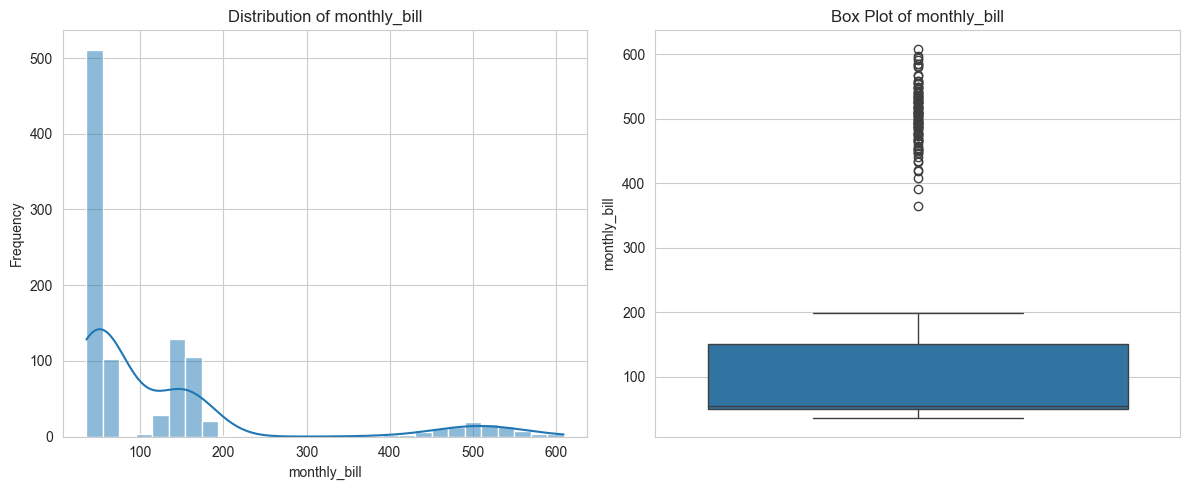

Displayed histogram and box plot for monthly_bill.


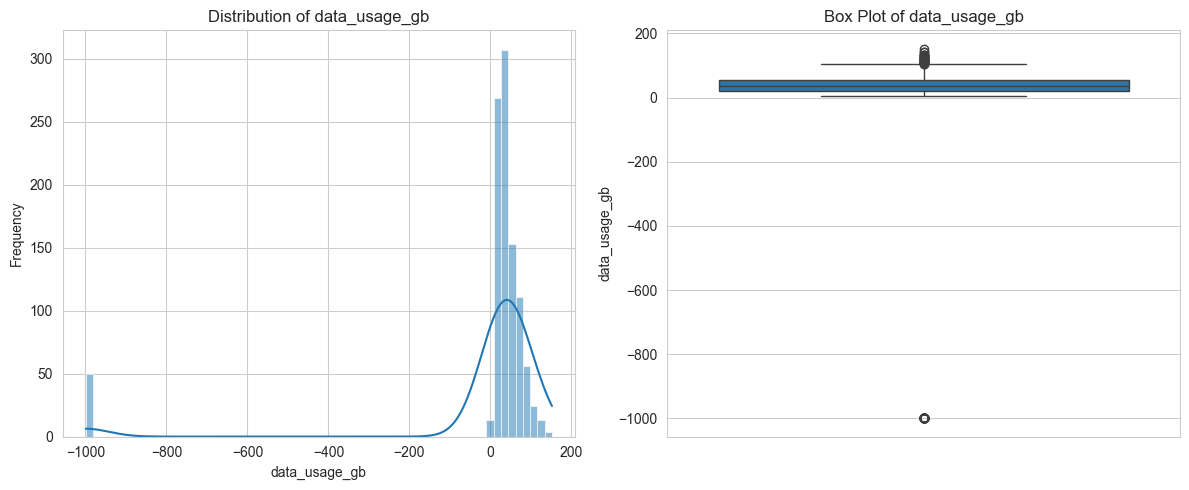

Displayed histogram and box plot for data_usage_gb.


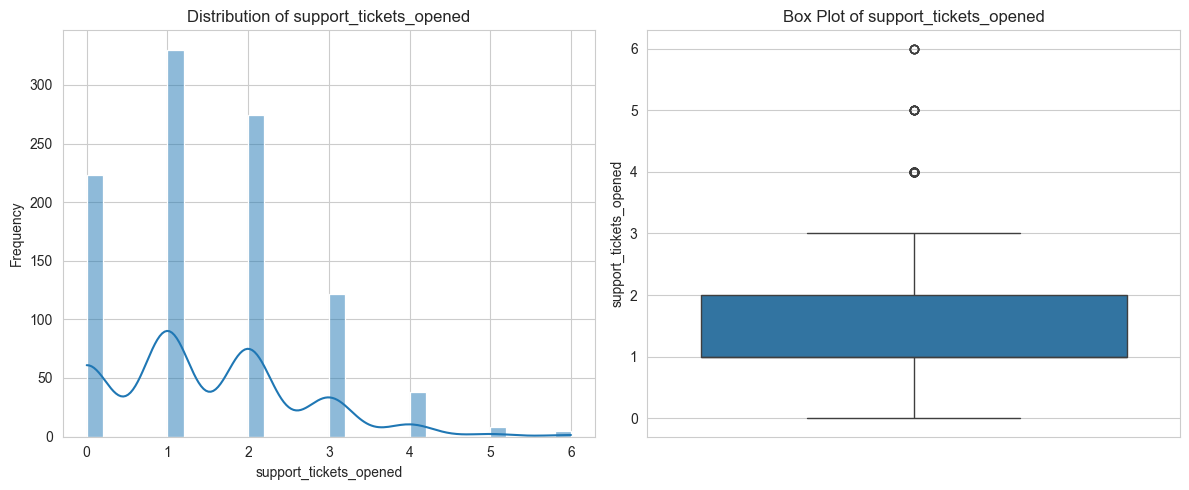

Displayed histogram and box plot for support_tickets_opened.


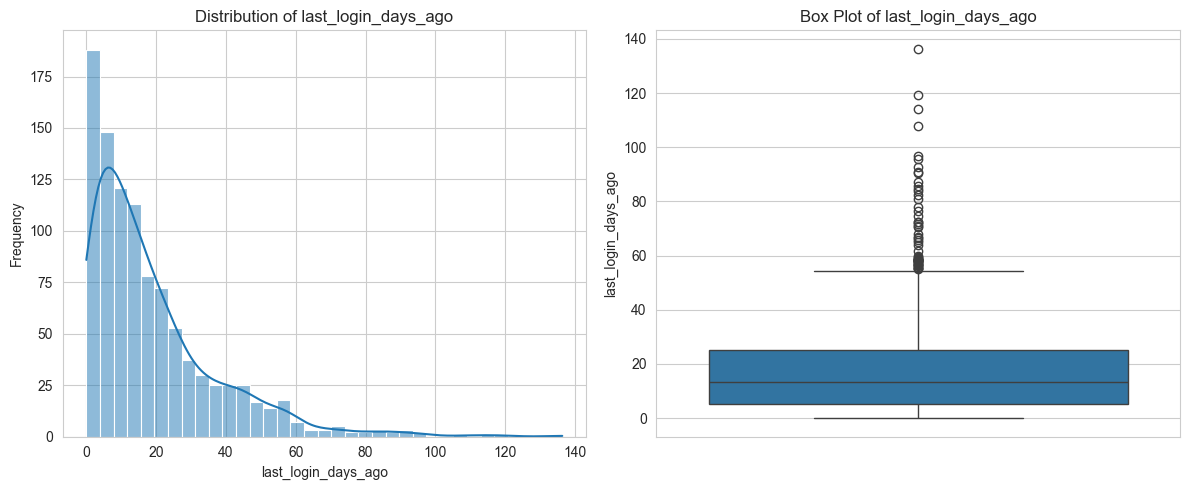

Displayed histogram and box plot for last_login_days_ago.


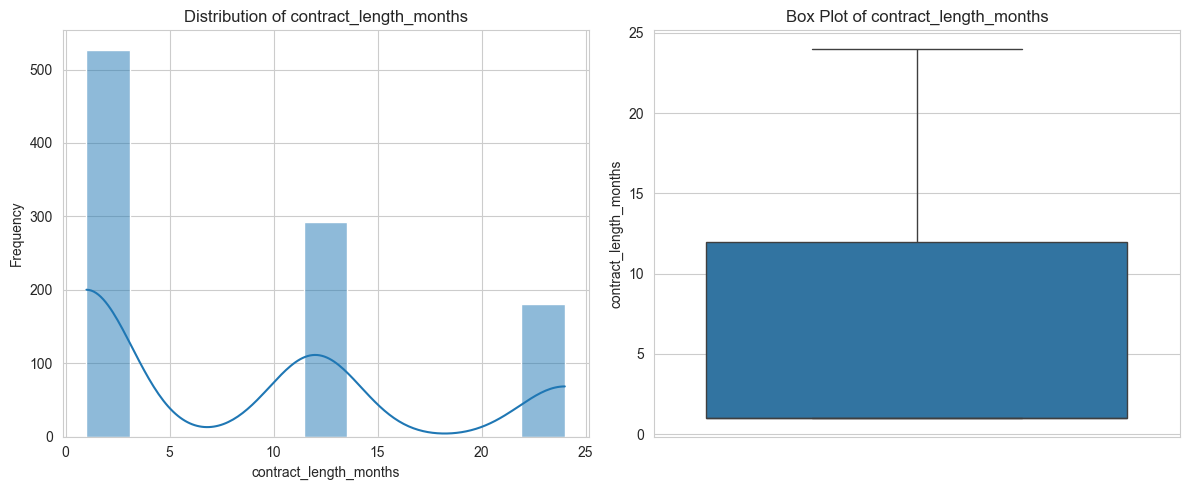

Displayed histogram and box plot for contract_length_months.


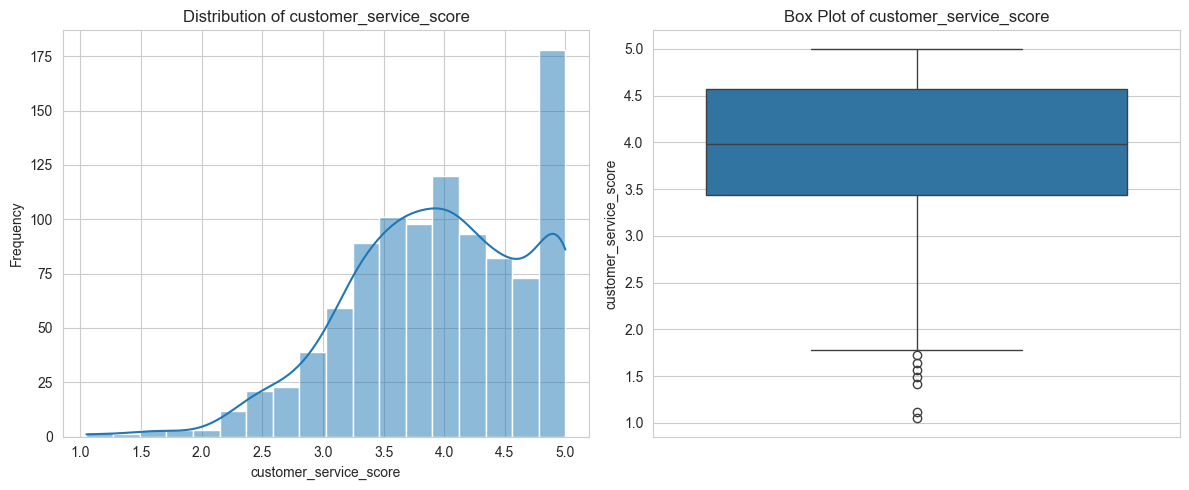

Displayed histogram and box plot for customer_service_score.

Visualizing distribution of the target variable 'churn':


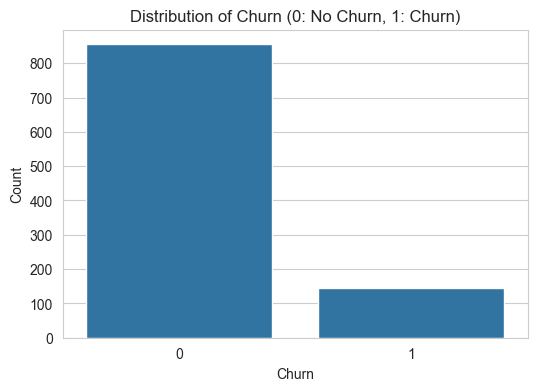

Displayed count plot for 'churn'.
Churn distribution:
churn
0    85.5
1    14.5
Name: proportion, dtype: float64

Visualizing relationships between features and 'churn':


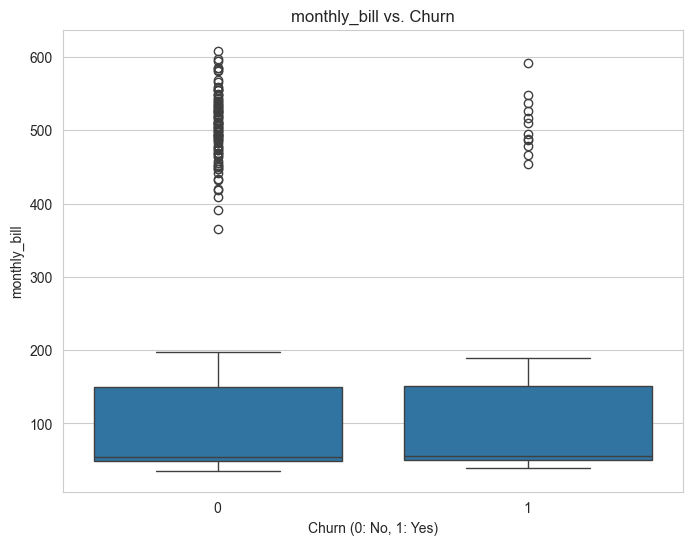

Displayed box plot for monthly_bill vs. Churn.


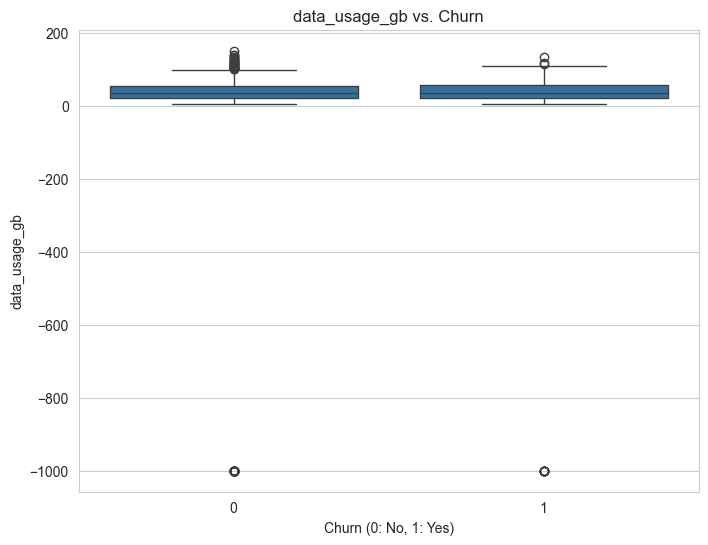

Displayed box plot for data_usage_gb vs. Churn.


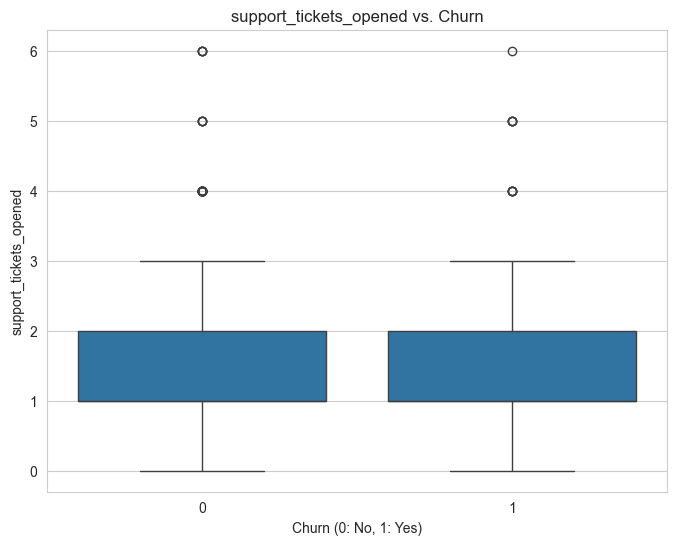

Displayed box plot for support_tickets_opened vs. Churn.


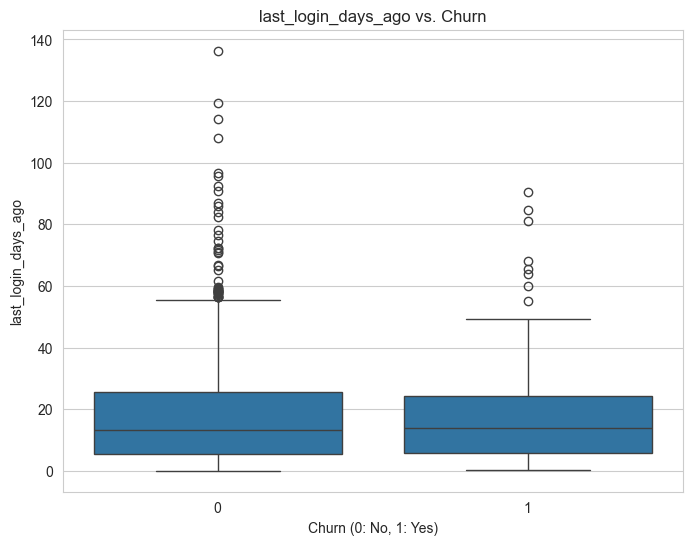

Displayed box plot for last_login_days_ago vs. Churn.


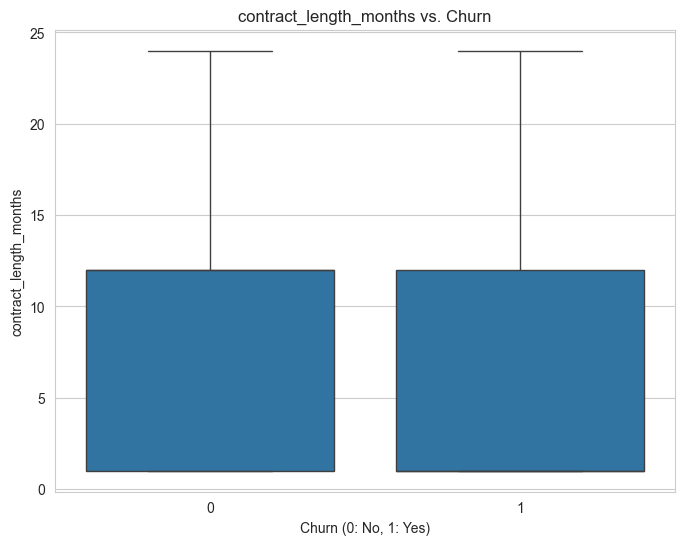

Displayed box plot for contract_length_months vs. Churn.


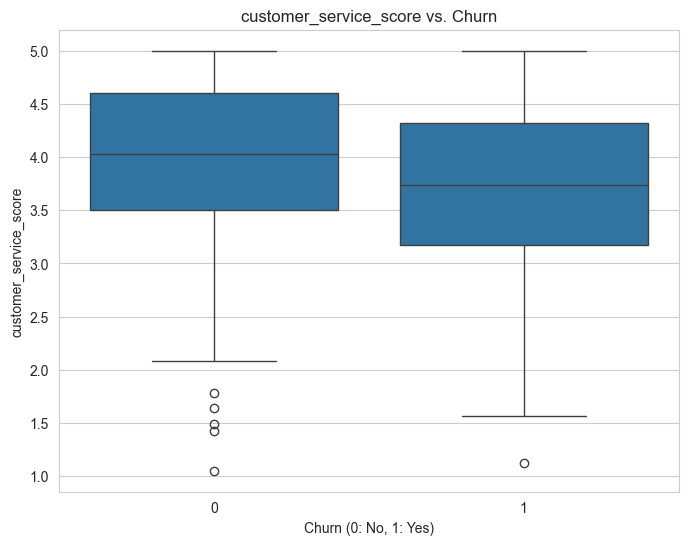

Displayed box plot for customer_service_score vs. Churn.


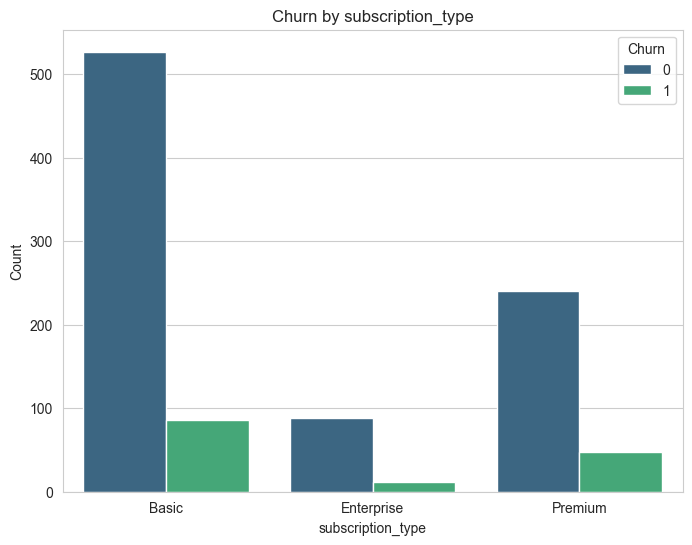

Displayed count plot for subscription_type vs. Churn.

Visualizing correlation matrix for numerical features:


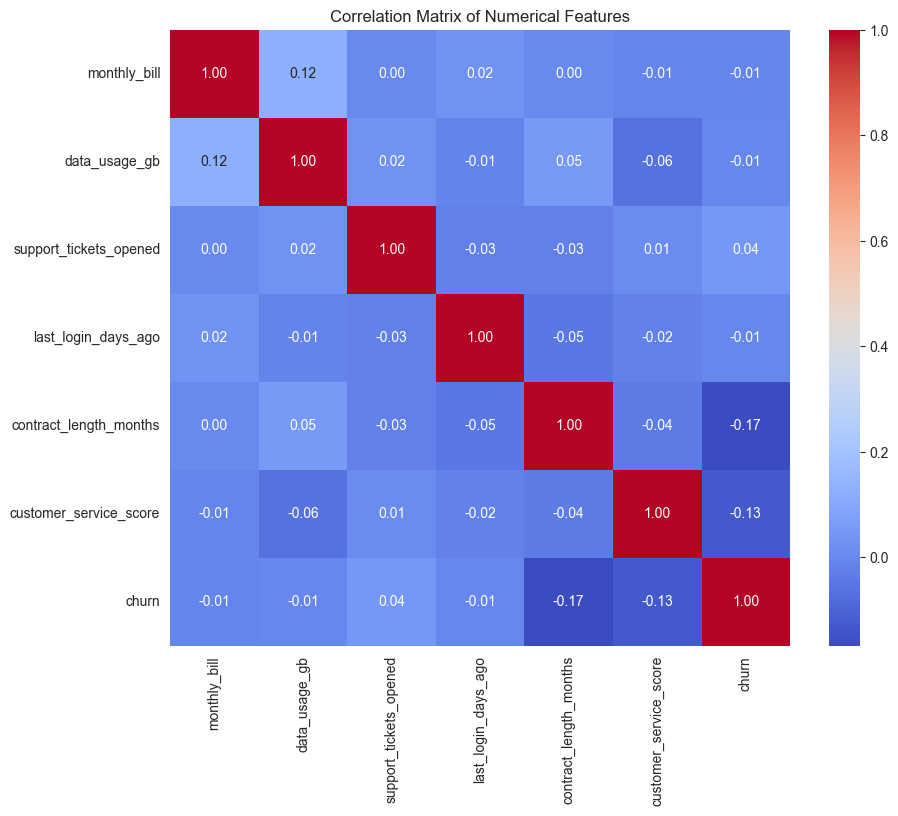

Displayed correlation matrix.

--- Phase 3: EDA with Plots Completed ---
The dataset has been cleaned and explored. Feature engineering can be performed based on these insights.


In [3]:
 # --- Phase 3: Exploratory Data Analysis (EDA) with Plots ---
print("\n--- Phase 3: Exploratory Data Analysis (EDA) with Plots ---")

# Set style for plots
sns.set_style("whitegrid")

# 1. Distribution of Numerical Features
print("\nVisualizing distributions of numerical features:")
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Exclude 'customer_id' if it's still present and treated as numerical
if 'customer_id' in numerical_features:
    numerical_features.remove('customer_id')
if 'churn' in numerical_features: # Exclude churn as it's our target
    numerical_features.remove('churn')

for col in numerical_features:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()
    print(f"Displayed histogram and box plot for {col}.")

# 2. Distribution of Target Variable (Churn)
print("\nVisualizing distribution of the target variable 'churn':")
if 'churn' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='churn', data=df)
    plt.title('Distribution of Churn (0: No Churn, 1: Churn)')
    plt.xlabel('Churn')
    plt.ylabel('Count')
    plt.show()
    print("Displayed count plot for 'churn'.")
    churn_percentage = df['churn'].value_counts(normalize=True) * 100
    print(f"Churn distribution:\n{churn_percentage}")
else:
    print("Cannot plot 'churn' distribution as it's not in the DataFrame.")


# 3. Relationship between Features and Target Variable (Churn)
print("\nVisualizing relationships between features and 'churn':")
# For numerical features vs. churn (using box plots or violin plots)
for col in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='churn', y=col, data=df)
    plt.title(f'{col} vs. Churn')
    plt.xlabel('Churn (0: No, 1: Yes)')
    plt.ylabel(col)
    plt.show()
    print(f"Displayed box plot for {col} vs. Churn.")

# Identify original categorical columns for plotting (since one-hot encoding is removed)
original_categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'customer_id' in original_categorical_cols: # Exclude identifier
    original_categorical_cols.remove('customer_id')

# For original categorical features vs. churn (using count plots or bar plots)
for col in original_categorical_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, hue='churn', data=df, palette='viridis')
    plt.title(f'Churn by {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Churn')
    plt.show()
    print(f"Displayed count plot for {col} vs. Churn.")


# 4. Correlation Matrix for Numerical Features
print("\nVisualizing correlation matrix for numerical features:")
# Ensure all columns are numerical for correlation matrix
df_numeric_for_corr = df.select_dtypes(include=['int64', 'float64'])
# Exclude 'customer_id' from correlation matrix if present
if 'customer_id' in df_numeric_for_corr.columns:
    df_numeric_for_corr = df_numeric_for_corr.drop(columns=['customer_id'])

if not df_numeric_for_corr.empty:
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_numeric_for_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()
    print("Displayed correlation matrix.")
else:
    print("No suitable numerical columns for correlation matrix.")

print("\n--- Phase 3: EDA with Plots Completed ---")
print("The dataset has been cleaned and explored. Feature engineering can be performed based on these insights.")

# Phase 4: Feature Engineering and Encoding

In [5]:
if not df.empty:
    # --- Phase 4: Feature Engineering and Encoding ---
    print("\n--- Phase 4: Feature Engineering and Encoding ---")

    # 1. Handle Categorical Features
    # Identify categorical columns (excluding 'customer_id' and 'churn')
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    if 'customer_id' in categorical_cols:
        categorical_cols.remove('customer_id')

    # Apply One-Hot Encoding
    # Justification: One-Hot Encoding creates new binary columns for each category,
    # which prevents the model from assuming an ordinal relationship between categories.
    if categorical_cols:
        print(f"Applying One-Hot Encoding to categorical columns: {categorical_cols}")
        df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    else:
        print("No categorical columns to one-hot encode.")

    # 2. Handle Target Variable
    # The 'churn' column is already numerical (0s and 1s) from the data generation script.
    # However, this step demonstrates how to handle a non-numerical target if it were present.
    if 'churn' in df.columns and df['churn'].dtype == 'object':
        print("Encoding the 'churn' target variable from object to numerical (0 and 1).")
        le = LabelEncoder()
        df['churn'] = le.fit_transform(df['churn'])
    else:
        print("Target variable 'churn' is already in a numerical format.")

    # 3. Final Check
    print("\nDataFrame head after encoding:")
    print(df.head())
    print("\nUpdated DataFrame Info:")
    df.info()

    print("\n--- Phase 4: Feature Engineering and Encoding Completed ---")
    print("The dataset is now fully numerical and ready for model training.")
else:
    print("\nDataFrame is empty. Cannot perform feature engineering and encoding.")


--- Phase 4: Feature Engineering and Encoding ---
No categorical columns to one-hot encode.
Target variable 'churn' is already in a numerical format.

DataFrame head after encoding:
  customer_id  monthly_bill  data_usage_gb  support_tickets_opened  \
0       C0001         50.89          11.55                       4   
1       C0002        520.19          75.44                       0   
2       C0003        152.05          41.84                       3   
3       C0004         43.32          10.40                       1   
4       C0005         51.90          24.67                       2   

   last_login_days_ago  contract_length_months  customer_service_score  churn  \
0                 4.59                      24                    4.02      1   
1                13.35                       1                    4.50      0   
2                42.12                       1                    4.15      0   
3                14.98                       1                    5.00  

# Phase 5: XGBoost Model Training and Evaluation


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

if not df.empty:
    print("\n--- Phase 5: XGBoost Model Training and Evaluation ---")
    
    # 1. Prepare Data for XGBoost
    # Define features (X) and target (y)
    # 'customer_id' is an identifier and should not be used as a feature for training.
    if 'churn' in df.columns and 'customer_id' in df.columns:
        X = df.drop(['churn', 'customer_id'], axis=1)
        y = df['churn']
        
        # Ensure all features are numerical before passing to XGBoost
        # This step is a safeguard, as previous phases should ensure this.
        X_numerical = X.select_dtypes(include=[np.number, np.bool_]) # Include boolean for one-hot encoded columns
        
        # 2. Split the data into training and testing sets
        # Using stratify=y ensures that the proportion of churn/non-churn
        # is maintained in both training and testing sets, which is crucial
        # for imbalanced datasets.
        X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=0.2, random_state=42, stratify=y)
        
        print(f"Training data shape: {X_train.shape}")
        print(f"Testing data shape: {X_test.shape}")
        
        # 3. Train the XGBoost Classifier
        print("\nInitializing and training the XGBoost Classifier...")
        # 'objective': 'binary:logistic' for binary classification (predicts probabilities)
        # 'eval_metric': 'logloss' is a common metric for classification problems
        # 'use_label_encoder=False': Suppresses a future deprecation warning
        # 'random_state': for reproducibility
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        )
        # Fit the model to the training data
        model.fit(X_train, y_train)
        
        # 4. Make predictions on the test set
        # The .predict() method outputs the class labels (0 or 1)
        y_pred = model.predict(X_test)
        
        # 5. Evaluate the model's performance
        print("\n--- Model Evaluation ---")
        # Calculate overall accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy on test set: {accuracy:.4f}")
        
        # Print a detailed classification report including precision, recall, f1-score
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))       


--- Phase 5: XGBoost Model Training and Evaluation ---
Training data shape: (800, 8)
Testing data shape: (200, 8)

Initializing and training the XGBoost Classifier...

--- Model Evaluation ---
Accuracy on test set: 0.8300

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       171
           1       0.22      0.07      0.11        29

    accuracy                           0.83       200
   macro avg       0.54      0.51      0.51       200
weighted avg       0.77      0.83      0.79       200



/usr/local/genuin/code/personal/DS-code-practice/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:06:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Phase 6: Model Evaluation and Testing with Unknown Samples


--- Phase 6: Model Evaluation and Testing with Unknown Samples ---

--- Comprehensive Model Evaluation ---
Accuracy: 0.8300

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       171
           1       0.22      0.07      0.11        29

    accuracy                           0.83       200
   macro avg       0.54      0.51      0.51       200
weighted avg       0.77      0.83      0.79       200

ROC AUC Score: 0.4985
F1-Score: 0.1053
Cohen's Kappa Score: 0.0393

Confusion Matrix:


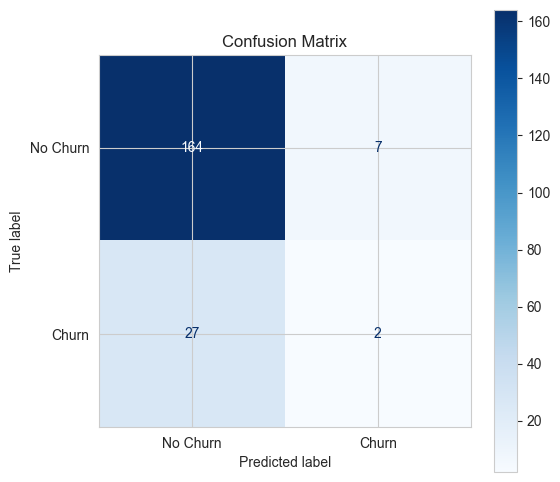

Displayed Confusion Matrix.


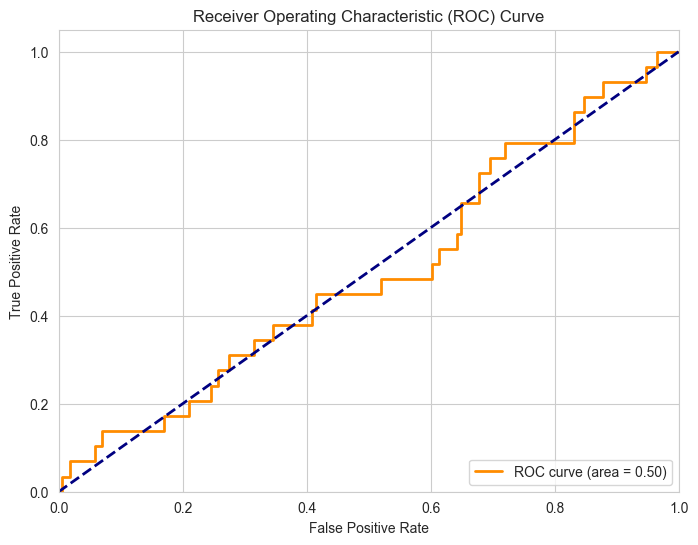

Displayed ROC Curve.


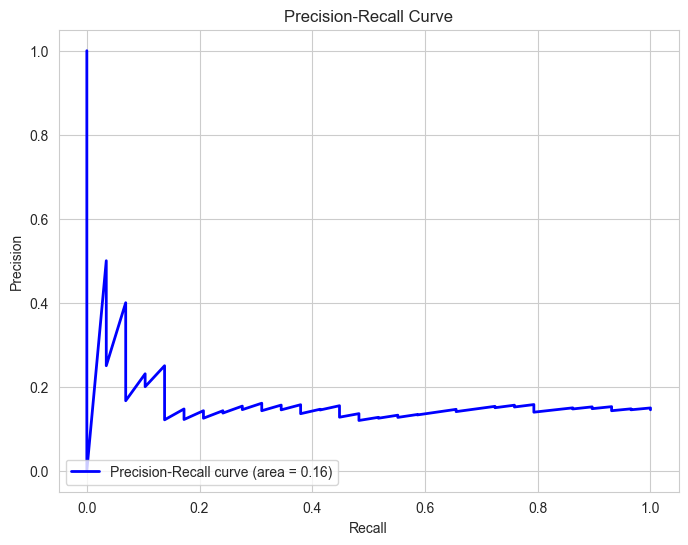

Displayed Precision-Recall Curve.

--- Testing with Unknown Sample Inputs ---

New, unknown customer data points:
   monthly_bill  data_usage_gb  support_tickets_opened  last_login_days_ago  \
0         120.0           30.0                       2                  5.5   
1          45.0           15.0                       0                 45.0   

   contract_length_months  customer_service_score  \
0                      12                     4.5   
1                       1                     2.5   

   subscription_type_Enterprise  subscription_type_Premium  
0                         False                       True  
1                         False                      False  

--- Prediction Results for New Samples ---
Customer 1:
  - Predicted Churn Status: will not churn
  - Probability of Churn: 0.0022
------------------------------
Customer 2:
  - Predicted Churn Status: will not churn
  - Probability of Churn: 0.0910
------------------------------

--- Phase 6: Completed

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt


if not df.empty:
    # --- Phase 6: Model Evaluation and Testing with Unknown Samples ---
    print("\n--- Phase 6: Model Evaluation and Testing with Unknown Samples ---")

    # 1. Make predictions on the test set for evaluation
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class (churn=1)

    # 2. Comprehensive Model Evaluation Metrics
    print("\n--- Comprehensive Model Evaluation ---")

    # Accuracy Score
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Classification Report (Precision, Recall, F1-Score)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # ROC AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # F1-Score (explicitly, though in classification report)
    f1 = f1_score(y_test, y_pred)
    print(f"F1-Score: {f1:.4f}")

    # Cohen's Kappa Score
    kappa = cohen_kappa_score(y_test, y_pred)
    print(f"Cohen's Kappa Score: {kappa:.4f}")

    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title('Confusion Matrix')
    plt.show()
    print("Displayed Confusion Matrix.")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("Displayed ROC Curve.")

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    print("Displayed Precision-Recall Curve.")

    # --- Testing with Unknown Sample Inputs ---
    print("\n--- Testing with Unknown Sample Inputs ---")

    # 1. Define two new, unseen customer profiles.
    # Note: These values must be consistent with the data schema.
    # For 'subscription_type_Enterprise' and 'subscription_type_Premium', we'll use booleans.
    # We must ensure the column order is correct for the model's input.
    new_data = pd.DataFrame({
        'monthly_bill': [120.0, 45.0],
        'data_usage_gb': [30.0, 15.0],
        'support_tickets_opened': [2, 0],
        'last_login_days_ago': [5.5, 45.0],
        'contract_length_months': [12, 1],
        'customer_service_score': [4.5, 2.5],
        'subscription_type_Enterprise': [False, False],
        'subscription_type_Premium': [True, False]
    })

    # The column order must be the same as the training data
    new_data = new_data[X_train.columns]
    
    print("\nNew, unknown customer data points:")
    print(new_data)

    # 2. Make predictions on the new data
    predictions = model.predict(new_data)
    prediction_probabilities = model.predict_proba(new_data)
    
    # 3. Print and interpret the results
    print("\n--- Prediction Results for New Samples ---")
    
    for i, pred in enumerate(predictions):
        customer_index = i + 1
        churn_status = "will churn" if pred == 1 else "will not churn"
        churn_prob = prediction_probabilities[i, 1]
        
        print(f"Customer {customer_index}:")
        print(f"  - Predicted Churn Status: {churn_status}")
        print(f"  - Probability of Churn: {churn_prob:.4f}")
        print("-" * 30)

    print("\n--- Phase 6: Completed ---")
    print("The model has been comprehensively evaluated and tested with new data points.")
else:
    print("\nDataFrame is empty. Cannot perform model evaluation and testing.")
